<a href="https://colab.research.google.com/github/HarshiniAiyyer/Relearning/blob/main/pytorch/3_Neural_Network_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 03. Neural Network Classification with Pytorch

### Architecture of a classification model

Inputs and outputs are always some form of numeric values.

- **Input layer shape** ( same as the no of features)
- **Hidden layer**: Problem specific, min 1, max unlimited
- **Neurons per hidden layer**: Problem specific generally 10 to 512.
- **Output layer shape**: 1 per class.
- **Hidden layer activation**: Usually RELU.
- **Output activation**: Sigmoid in binary classficiation, softmax for multiclass.
- **Loss function**: Binary cross entropy for Binary classification, whereas cross entropy for multiclass
- **Optimizer**: SGD, Adam

## A. Binary Classification Problem

In [71]:
import torch
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import datasets

### Making classification data and getting it ready

In [72]:
from sklearn.datasets import make_circles

#make 1000 samples
nsamples = 1000

#create  circles

x, y = make_circles(nsamples, noise = 0.03, random_state = 42)


In [73]:
len(x), len(y)

(1000, 1000)

### Making dataframe of circles

In [74]:
circles = pd.DataFrame({"X1": x[:,0],
                       "X2": x[:,1],
                       "label": y})
circles.head(5)

,X1,X2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0


### Visualizing

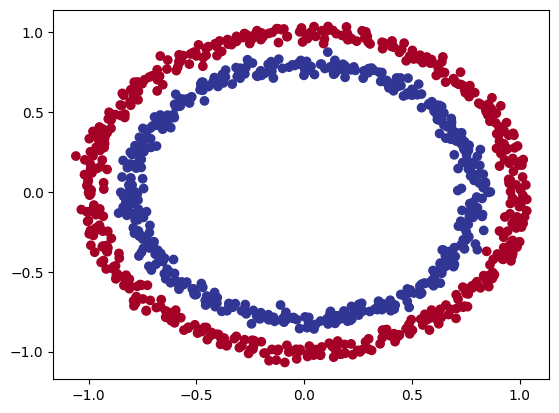

In [75]:
plt.scatter(x = x[:,0], y = x[:,1], c = y, cmap = plt.cm.RdYlBu)

### Turn data to tensors

#### Check input and output shapes

In [76]:
x.shape, y.shape

((1000, 2), (1000,))

In [77]:
x = torch.from_numpy(x).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

x[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

### Train test splits

In [78]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state = 42)

len(x_train), len(x_test), len(y_train), len(y_test)

(800, 200, 800, 200)

### Build the model

- setup device agnostic mode
- construct the model (by subclassing nn.Module)
- define loss function and optimizer
- create a training and testing loops

In [79]:
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [80]:
x_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

- Subclass nn.module
- create 2 nn.linear layers
- define forward method
- define an instance model class and send it to target device

##### Construct a model that subclasses nn.Module

In [81]:
class Circle(nn.Module):

  def __init__(self) -> None:
    super().__init__()

    #2. CREATE 2 NN.LINEAR LAYERS FOR HANDLING DATA SHAPES
    self.layer_1 = nn.Linear(in_features = 2, out_features = 5)#takes in 2 features and upscales to 5
    self.layer_2 = nn.Linear(in_features=5, out_features = 1) # takes the features from the previous out layer and becomes the next in features

    #3. FORWARD FUNCTION
    def forward(self, x):
      return self.layer_2(self.layer_1(x)) #layer 1 goes into layer 2
      #x -> 1 -> 2 -> output


#4. CREATE CLASS INSTANCE
model0 = Circle().to(device)
model0


Circle(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
)

In [82]:
next(model0.parameters()).device

device(type='cuda', index=0)

#### nn.Sequential

Alternative of the previous layers we defined in the prev code cell.

In [83]:
model0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1),
).to(device)

model0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [84]:
model0.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]], device='cuda:0')),
             ('0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]], device='cuda:0')),
             ('1.bias', tensor([-0.1213], device='cuda:0'))])

#### Make predictions

In [85]:
# Make predictions
with torch.inference_mode():
  untrained_preds = model0(x_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(x_test)}, Shape: {x_test.shape}")
print(f"\nFirst 10 predictions:\n{torch.round(untrained_preds[:10])}")
print(f"\nFirst 10 labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200, 2])

First 10 predictions:
tensor([[-0.],
        [-0.],
        [0.],
        [-0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [-0.]], device='cuda:0')

First 10 labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


#### Setup loss function and optimizer

- bcewithlogitsloss is more stable than bce with sequential

In [86]:
lossfn = nn.BCEWithLogitsLoss() # sigmoid activation function
op = torch.optim.SGD(params = model0.parameters(),
                     lr= 0.01)

#### Accuracy of the model

In [87]:
def acc(y_true, y_pred):
  corr = torch.eq(y_true, y_pred).sum().item()
  accu = (corr / len(y_pred)) * 100
  return accu

#### Train model

1. Forward pass
2. Calculate loss
3. Optimizer zero grad
4. Loss backward (backpropagation)
5. Optimizer (gradient descent)


##### Going from raw logits -> prediction probabilities -> prediction labels

- **Logits are the raw outputs of the models from the forward pass.**

Our model outputs wud be raw logits.

1.  **Logits -> prediction probabilities**

- by passing them to some kind of activation function (e.g. classification and softmax for multiclass classification)

2. **convert our model's prediction probabs to prediction labels**

- by either rounding them or taking the argmax. rounding them is for binary classification and argmax is for softmax.

In [88]:
#first 5 outputs of the forward pass on the test data

model0.eval()

with torch.inference_mode():
  y_logits = model0(x_test.to(device))[:5]
y_logits

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]], device='cuda:0')

##### Use sigmoid on the logits

In [89]:
ypredprobs = torch.sigmoid(y_logits)
ypredprobs

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]], device='cuda:0')

In [90]:
torch.round(ypredprobs)

tensor([[0.],
        [0.],
        [1.],
        [0.],
        [1.]], device='cuda:0')

For our prediction probabilities, we need to perform a range style rounding on them.

- ypredprobs >= 0.5, y = 1 (class 1)

- ypredprobs <0.5, y = 0 (class 0)

##### Find predicted labels

In [91]:
ypreds = torch.round(ypredprobs)

##### Logits -> pred probs -> pred labels

In [92]:
ypredlabels = torch.round(torch.sigmoid(model0(x_test.to(device))[:5]))

##### Check for equality

In [93]:
print(torch.eq(ypreds.squeeze(), ypredlabels.squeeze()))

tensor([True, True, True, True, True], device='cuda:0')


In [94]:
ypreds.squeeze()

tensor([0., 0., 1., 0., 1.], device='cuda:0')

### Building a training and testing loop

In [95]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 100

#put data to target device
x_train, y_train = x_train.to(device), y_train.to(device)

x_test, y_test = x_test.to(device), y_test.to(device)

#### Training and evaluation loop

- Activation function converts raw logits into pred probs

In [96]:
epochs = 100

for epoch in range(epochs):
  model0.train()

  #1.FORWARD PASS
  y_logits = model0(x_train).squeeze()

  #logits -> pred_probs-> pred labels
  ypred = torch.round(torch.sigmoid(y_logits))

  #2. LOSS / ACCURACY
  loss = lossfn(y_logits, y_train)
  # nn.bcewithlogitsless expects raw logits as input

  #loss = lossfn(torch.sigmoid(y_logits), y_train)
  # nn.bceloss expects prediction probs as input
  accu = acc(y_true = y_train, y_pred = ypred)

  #3. OPTIMIZER ZERO GRAD
  op.zero_grad()

  #4. LOSS BACKWARD
  loss.backward()

  #5. OPTIMIZER STEP (GRADIENT DESCENT)
  op.step()

  #testing
  model0.eval()

  with torch.inference_mode():
    #1. forward pass
    test_logits = model0(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. calculate loss and acc for test
    testloss = lossfn(test_logits, y_test)
    testacc = acc(y_true = y_test, y_pred = test_pred)


  #print out what is happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss:.5f}, acc: {accu:.2f} | test loss: {testloss:.5f}| test acc: {testacc:.2f}")

epoch: 0 | Loss: 0.69796, acc: 51.88 | test loss: 0.69460| test acc: 57.50
epoch: 10 | Loss: 0.69768, acc: 52.00 | test loss: 0.69438| test acc: 58.00
epoch: 20 | Loss: 0.69742, acc: 52.00 | test loss: 0.69418| test acc: 57.50
epoch: 30 | Loss: 0.69717, acc: 52.00 | test loss: 0.69401| test acc: 56.50
epoch: 40 | Loss: 0.69695, acc: 51.62 | test loss: 0.69385| test acc: 56.50
epoch: 50 | Loss: 0.69675, acc: 51.38 | test loss: 0.69370| test acc: 56.00
epoch: 60 | Loss: 0.69656, acc: 51.38 | test loss: 0.69357| test acc: 56.00
epoch: 70 | Loss: 0.69638, acc: 51.38 | test loss: 0.69345| test acc: 56.50
epoch: 80 | Loss: 0.69621, acc: 51.25 | test loss: 0.69334| test acc: 56.50
epoch: 90 | Loss: 0.69606, acc: 51.38 | test loss: 0.69324| test acc: 55.00


From the metrics it looks like our model isnt learning anything from the low accuracy score.

#### Visualziing and evaluating the model

- plot_decision_boundary() inbuilt function from the course github repo ```https://github.com/mrdbourke/pytorch-deep-learning/blob/main/helper_functions.py```

In [97]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary


helper_functions.py already exists, skipping download


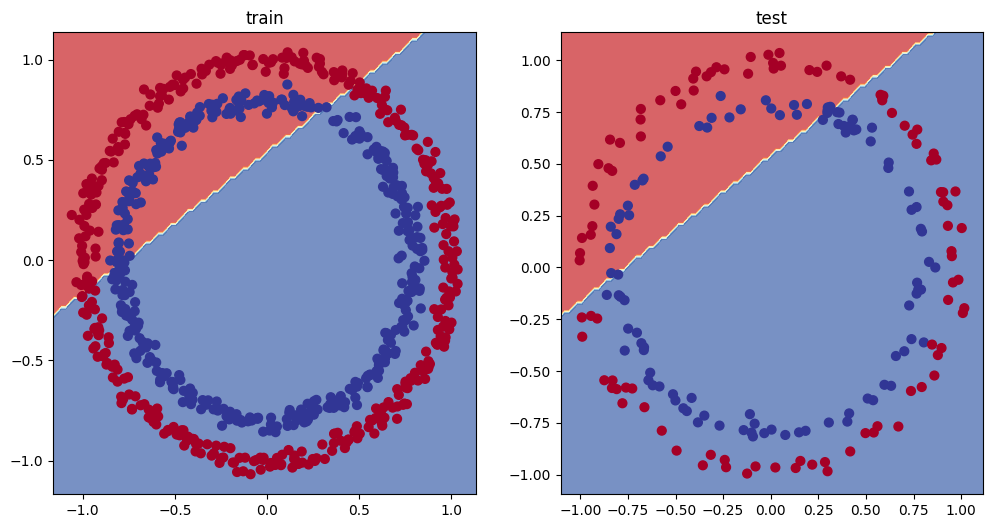

In [98]:
#plot decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model0, x_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model0, x_test, y_test)

### Improving the model (from a model Persepctive)

- add more layers: give the model more chances to learn about the data

- add more hidden units: go from 5 to 10 hidden units

- more epochs

- change the activation function

- change the learning rate

- change loss

Lets add more hidden units (5->10), and increase the number of layers ( 2->3) and increase the number of epochs (100 -> 1000).

In [99]:
class Circle(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1 = nn.Linear(in_features = 2, out_features = 10)
    self.layer_2 = nn.Linear(in_features=10, out_features = 10)
    self.layer_3 = nn.Linear(in_features = 10, out_features = 1)

  def forward(self, x):
    # This way of writing operations leverages speed ups
    return self.layer_3(self.layer_2(self.layer_1(x)))

model1 = Circle().to(device)
model1

Circle(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
)

In [100]:
#create a loss function

lossfn = nn.BCEWithLogitsLoss()

#optimizer
opt = torch.optim.SGD(params=model1.parameters(), lr = 0.1)

In [101]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)

x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model1.train()

  #forward pass
  ylogits = model1(x_train).squeeze()
  ypred = torch.round(torch.sigmoid(ylogits))

  #calculate loss and acc
  loss = lossfn(ylogits, y_train)
  #loss = lossfn(torch.sigmoid(y_logits), y_train)
  # nn.bceloss expects prediction probs as input
  accu = acc(y_true = y_train, y_pred = ypred)

  #3. OPTIMIZER ZERO GRAD
  op.zero_grad()

  #4. LOSS BACKWARD
  loss.backward()

  #5. OPTIMIZER STEP (GRADIENT DESCENT)
  op.step()

  #testing
  model0.eval()

  with torch.inference_mode():
    #1. forward pass
    test_logits = model1(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. calculate loss and acc for test
    testloss = lossfn(test_logits, y_test)
    testacc = acc(y_true = y_test, y_pred = test_pred)


  #print out what is happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss:.5f}, acc: {accu:.2f} | test loss: {testloss:.5f}| test acc: {testacc:.2f}")

epoch: 0 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 10 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 20 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 30 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 40 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 50 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 60 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 70 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 80 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 90 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 100 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 110 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 120 | Loss: 0.69396, acc: 50.88 | test loss: 0.69261| test acc: 51.00
epoch: 130

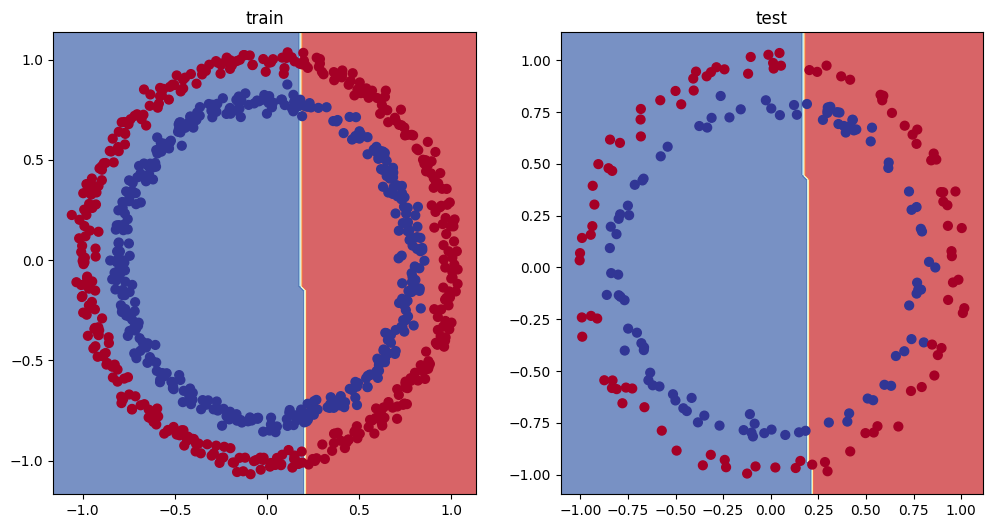

In [102]:
#plot decision boundary

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.title("train")
plot_decision_boundary(model1, x_train, y_train)

plt.subplot(1,2,2)
plt.title("test")
plot_decision_boundary(model1, x_test, y_test)

### Preparing data to see if our model can fit a straight line

troubleshoot a larger problem to test out a smaller problem

In [103]:
# Create some data (same as notebook 01)
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias # linear regression formula

# Check the data
print(len(X_regression))
X_regression[:5], y_regression[:5]

100


(tensor([[0.0000],
         [0.0100],
         [0.0200],
         [0.0300],
         [0.0400]]),
 tensor([[0.3000],
         [0.3070],
         [0.3140],
         [0.3210],
         [0.3280]]))

In [104]:
# Create train and test splits
train_split = int(0.8 * len(X_regression)) # 80% of data used for training set
X_train_regression, y_train_regression = X_regression[:train_split], y_regression[:train_split]
X_test_regression, y_test_regression = X_regression[train_split:], y_regression[train_split:]

# Check the lengths of each split
print(len(X_train_regression),
    len(y_train_regression),
    len(X_test_regression),
    len(y_test_regression))

80 80 20 20


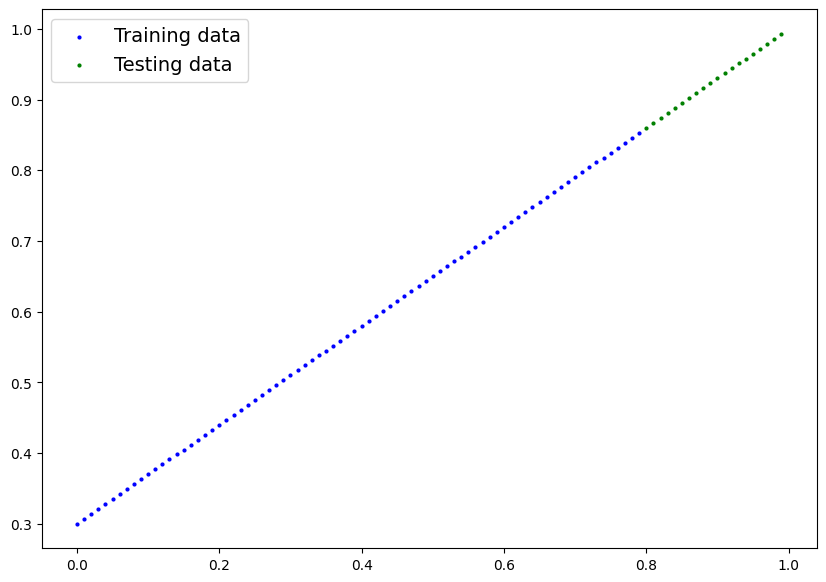

In [105]:
plot_predictions(train_data=X_train_regression,
    train_labels=y_train_regression,
    test_data=X_test_regression,
    test_labels=y_test_regression
);

#### Adjust model 1 to fit a straight line

In [106]:
# Same architecture as model_1 (but using nn.Sequential)
model_2 = nn.Sequential(
    nn.Linear(in_features=1, out_features=10),
    nn.Linear(in_features=10, out_features=10),
    nn.Linear(in_features=10, out_features=1)
).to(device)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=10, bias=True)
  (2): Linear(in_features=10, out_features=1, bias=True)
)

In [107]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(model_2.parameters(), lr=0.1)

In [108]:
# Train the model
torch.manual_seed(42)

# Set the number of epochs
epochs = 1000

# Put data to target device
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(epochs):
    ### Training
    # 1. Forward pass
    y_pred = model_2(X_train_regression)

    # 2. Calculate loss (no accuracy since it's a regression problem, not classification)
    loss = loss_fn(y_pred, y_train_regression)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_pred = model_2(X_test_regression)
      # 2. Calculate the loss
      test_loss = loss_fn(test_pred, y_test_regression)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Train loss: {loss:.5f}, Test loss: {test_loss:.5f}")

Epoch: 0 | Train loss: 0.75986, Test loss: 0.54143
Epoch: 100 | Train loss: 0.09309, Test loss: 0.02901
Epoch: 200 | Train loss: 0.07376, Test loss: 0.02850
Epoch: 300 | Train loss: 0.06745, Test loss: 0.00615
Epoch: 400 | Train loss: 0.06107, Test loss: 0.02004
Epoch: 500 | Train loss: 0.05698, Test loss: 0.01061
Epoch: 600 | Train loss: 0.04857, Test loss: 0.01326
Epoch: 700 | Train loss: 0.06109, Test loss: 0.02127
Epoch: 800 | Train loss: 0.05599, Test loss: 0.01426
Epoch: 900 | Train loss: 0.05571, Test loss: 0.00603


#### Model evaluation

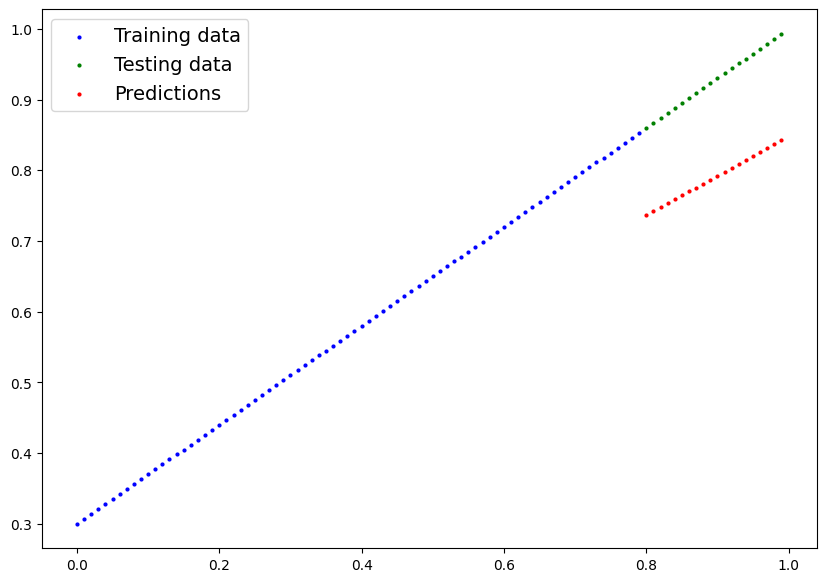

In [109]:
# Turn on evaluation mode
model_2.eval()

# Make predictions (inference)
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot data and predictions with data on the CPU (matplotlib can't handle data on the GPU)
# (try removing .cpu() from one of the below and see what happens)
plot_predictions(train_data=X_train_regression.cpu(),
                 train_labels=y_train_regression.cpu(),
                 test_data=X_test_regression.cpu(),
                 test_labels=y_test_regression.cpu(),
                 predictions=y_preds.cpu());

The problem here is we are trying make a linear function learn on a non linear or circular data.

thats why our earlier model cudnt learn properly.

### The missing piece: non-linearity

- We've seen our model can draw straight (linear) lines, thanks to its linear layers.

But how about we give it the capacity to draw non-straight (non-linear) lines?

How?

Let's find out.

#### Recreating non linear data

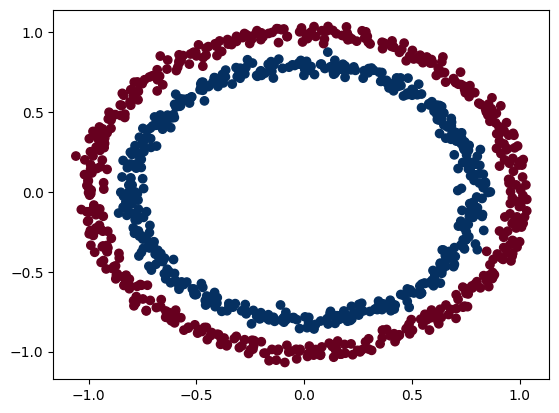

In [110]:
# Make and plot data
import matplotlib.pyplot as plt
from sklearn.datasets import make_circles

n_samples = 1000

X, y = make_circles(n_samples=1000,
    noise=0.03,
    random_state=42,
)

plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.RdBu);

#### Train test split

In [111]:
# Convert to tensors and split into train and test sets
import torch
from sklearn.model_selection import train_test_split

# Turn data into tensors
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42
)

X_train[:5], y_train[:5]

(tensor([[ 0.6579, -0.4651],
         [ 0.6319, -0.7347],
         [-1.0086, -0.1240],
         [-0.9666, -0.2256],
         [-0.1666,  0.7994]]),
 tensor([1., 0., 0., 0., 1.]))

#### build a model with non linearity

- linear is straight line
- non linear is non straight line

We can use non linear activation function (relu)

In [112]:
#build a model with non linear activation function

# Build model with non-linear activation function
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU() # <- add in ReLU activation function
        # Can also put sigmoid in the model
        # This would mean you don't need to use it on the predictions
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
      # Intersperse the ReLU activation function between layers
       return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model_3 = CircleModelV2().to(device)
print(model_3)


CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


#### optimzier and loss

In [113]:
# Setup loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_3.parameters(), lr=0.1)

### Train a model with non linearity

In [114]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000

x_train, y_train = x_train.to(device), y_train.to(device)

x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model_3.train()

  #forward pass
  ylogits = model_3(x_train).squeeze()
  ypred = torch.round(torch.sigmoid(ylogits))

  #calculate loss and acc
  loss = lossfn(ylogits, y_train)
  #loss = lossfn(torch.sigmoid(y_logits), y_train)
  # nn.bceloss expects prediction probs as input
  accu = acc(y_true = y_train, y_pred = ypred)

  #3. OPTIMIZER ZERO GRAD
  optimizer.zero_grad()

  #4. LOSS BACKWARD
  loss.backward()

  #5. OPTIMIZER STEP (GRADIENT DESCENT)
  optimizer.step()

  #testing
  model_3.eval()

  with torch.inference_mode():
    #1. forward pass
    test_logits = model_3(x_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #2. calculate loss and acc for test
    testloss = lossfn(test_logits, y_test)
    testacc = acc(y_true = y_test, y_pred = test_pred)


  #print out what is happening
  if epoch % 10 == 0:
    print(f"epoch: {epoch} | Loss: {loss:.5f}, acc: {accu:.2f} | test loss: {testloss:.5f}| test acc: {testacc:.2f}")

epoch: 0 | Loss: 0.69295, acc: 50.00 | test loss: 0.69319| test acc: 50.00
epoch: 10 | Loss: 0.69248, acc: 50.50 | test loss: 0.69260| test acc: 50.00
epoch: 20 | Loss: 0.69225, acc: 59.13 | test loss: 0.69231| test acc: 56.50
epoch: 30 | Loss: 0.69209, acc: 70.25 | test loss: 0.69212| test acc: 68.00
epoch: 40 | Loss: 0.69195, acc: 68.38 | test loss: 0.69195| test acc: 71.00
epoch: 50 | Loss: 0.69181, acc: 58.25 | test loss: 0.69177| test acc: 58.00
epoch: 60 | Loss: 0.69168, acc: 54.00 | test loss: 0.69161| test acc: 54.50
epoch: 70 | Loss: 0.69155, acc: 53.12 | test loss: 0.69146| test acc: 53.00
epoch: 80 | Loss: 0.69141, acc: 52.62 | test loss: 0.69132| test acc: 53.00
epoch: 90 | Loss: 0.69128, acc: 52.75 | test loss: 0.69117| test acc: 53.00
epoch: 100 | Loss: 0.69115, acc: 52.88 | test loss: 0.69102| test acc: 52.50
epoch: 110 | Loss: 0.69103, acc: 52.88 | test loss: 0.69088| test acc: 53.50
epoch: 120 | Loss: 0.69090, acc: 53.12 | test loss: 0.69074| test acc: 54.00
epoch: 130

#### Evaluating a model trained with non linear activation functions

In [115]:
# Make predictions
model_3.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_3(X_test.to(device)))).squeeze()
y_preds[:10], y[:10] # want preds in same format as truth labels

(tensor([1., 0., 1., 0., 0., 1., 0., 0., 1., 0.], device='cuda:0'),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

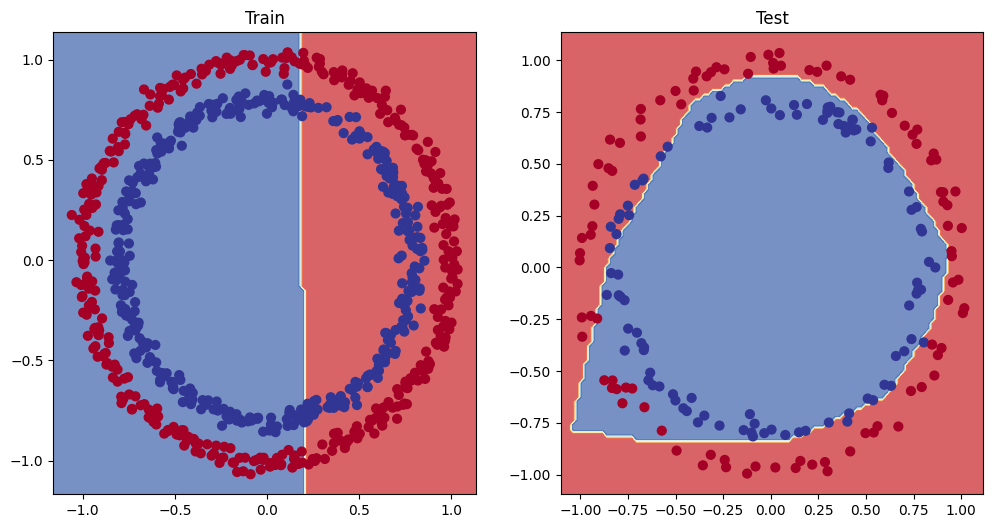

In [116]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_3, X_test, y_test) # model_3 = has non-linearity

### Replicating non linear activation function


In [117]:
#creeate a tensor

a = torch.arange(-10,10,1, dtype = torch.float32)
a.dtype

torch.float32

In [118]:
a

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

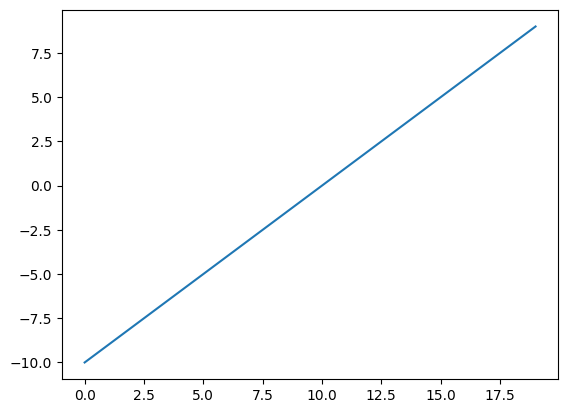

In [119]:
plt.plot(a)

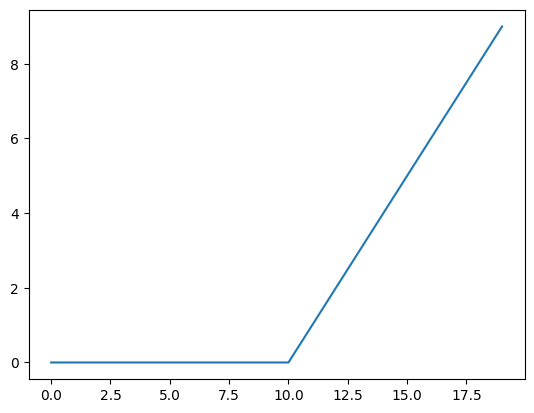

In [120]:
plt.plot(torch.relu(a))

#### Create a relu function

In [121]:
def relu(x: torch.Tensor) -> torch.Tensor:
  return torch.maximum(torch.tensor(0),x)

relu(a)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

#### create sigmoid function

In [122]:
# Create a custom sigmoid function
def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

# Test custom sigmoid on toy tensor
sigmoid(a)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

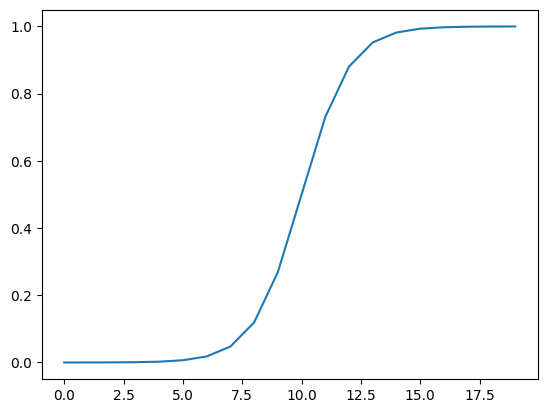

In [123]:
# Plot sigmoid activated toy tensor
plt.plot(sigmoid(a));

## B. Multiclass Classification Problem

### Creating a toy multiclass dataset

In [124]:
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

#### Set hyperparameters

In [125]:
NUM_CLASSES = 4
NUM_FEATURES = 2

RANDOM_SEED = 42

#### Create multi-class data

In [126]:
xblob, yblob = make_blobs(n_samples = 1000, n_features = NUM_FEATURES,
                          centers = NUM_CLASSES, cluster_std = 1.5,
                          random_state = RANDOM_SEED)

#### Turn data into tensors

In [127]:
# Ensure xblob and yblob are numpy arrays before converting to tensor
# This makes the cell re-runnable even if xblob/yblob were already tensors
if isinstance(xblob, torch.Tensor):
    xblob = xblob.cpu().numpy()
if isinstance(yblob, torch.Tensor):
    yblob = yblob.cpu().numpy()

xblob = torch.from_numpy(xblob).type(torch.float)
yblob = torch.from_numpy(yblob).type(torch.long)

#### Split into train and test

In [128]:
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(xblob,
                                                    yblob,
                                                    test_size=0.2,
                                                    random_state=RANDOM_SEED
)

#### Visualize

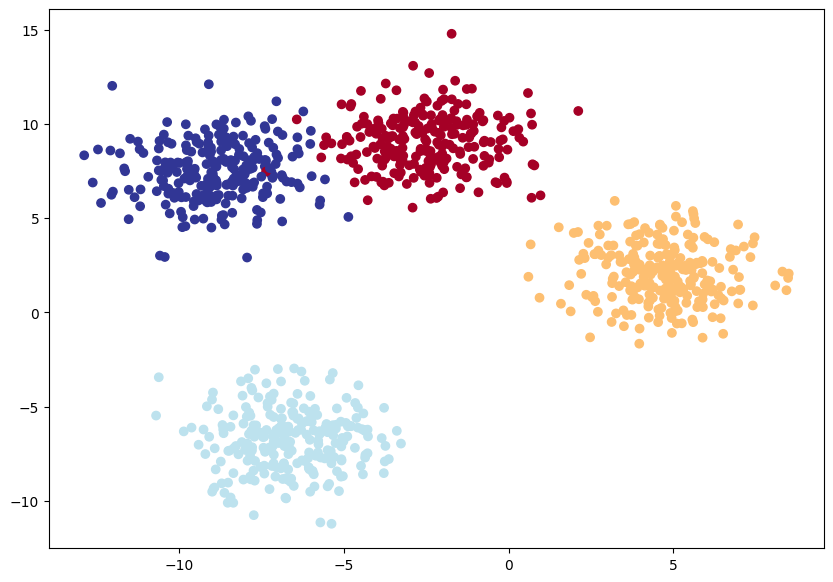

In [129]:
plt.figure(figsize=(10,7))
plt.scatter(xblob[:,0], xblob[:,1], c = yblob, cmap=plt.cm.RdYlBu)

### Building a multiclass classification model in Pytorch

In [130]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [143]:
class BlobModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=16): # Increased hidden_units
    super().__init__()

    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features)
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

#create an instance of BlobModel and send it to the target

model4 = BlobModel(input_features=2, output_features=4, hidden_units=16).to(device) # Increased hidden_units

model4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=16, bias=True)
    (1): ReLU()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): ReLU()
    (4): Linear(in_features=16, out_features=4, bias=True)
  )
)

In [132]:
torch.unique(y_train)

tensor([0, 1, 2, 3])

Loss function and optimizer

In [145]:
lossfn = nn.CrossEntropyLoss()
opt = torch.optim.SGD(params=model4.parameters(),lr=0.1) # Corrected model to model4

#### Getting prediction probabilities for a multiclass Pytorch model

logits (raw output) -> pred probs (use torch.softmax) -> pred labels (take the argmax of the prediction probabilities)

In [134]:
#get raw outputs

model4.eval()
with torch.inference_mode():
  y_preds = model4(x_test.to(device))

y_preds[:10]

tensor([[ 0.2012, -0.3399,  0.0384, -0.0197],
        [ 0.1854, -0.3857, -0.0116, -0.0469],
        [ 0.2536, -0.2390,  0.1556,  0.0181],
        [ 0.1860, -0.3692,  0.0045, -0.0307],
        [ 0.2444, -0.2795,  0.1278, -0.0108],
        [ 0.2007, -0.2808,  0.0698, -0.0482],
        [ 0.0700, -0.3384, -0.1486, -0.2127],
        [ 0.0634, -0.3189, -0.1449, -0.2180],
        [ 0.2521, -0.2392,  0.1543,  0.0197],
        [ 0.1848, -0.3871, -0.0153, -0.0480]], device='cuda:0')

In [135]:
y_test[:10]

tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])

We have to turn the logits to whatever is in the y_test format.

In [136]:
# Make prediction logits with model
y_logits = model4(x_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.2012, -0.3399,  0.0384, -0.0197],
        [ 0.1854, -0.3857, -0.0116, -0.0469],
        [ 0.2536, -0.2390,  0.1556,  0.0181],
        [ 0.1860, -0.3692,  0.0045, -0.0307],
        [ 0.2444, -0.2795,  0.1278, -0.0108]], device='cuda:0',
       grad_fn=<SliceBackward0>)
tensor([[0.3092, 0.1800, 0.2628, 0.2480],
        [0.3146, 0.1777, 0.2583, 0.2494],
        [0.3023, 0.1847, 0.2741, 0.2389],
        [0.3112, 0.1786, 0.2596, 0.2506],
        [0.3070, 0.1818, 0.2733, 0.2379]], device='cuda:0',
       grad_fn=<SliceBackward0>)


#### Convert model prediction probabilities to prediction labels

In [137]:
y_pred = torch.argmax(y_pred_probs, dim = 1)
y_pred

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')

Everything is zero here because our model hasnt been trained yet.

### Creating a training loop and testing loop for a multiclass Pytorch model

#### Fit the multiclass model to the data

In [146]:
def acc(y_true, y_pred):
  corr = torch.eq(y_true, y_pred).sum().item()
  accu = (corr / len(y_pred)) * 100
  return accu

torch.manual_seed(42)
torch.cuda.manual_seed(42)

epochs = 1000 # Increased epochs

x_train, y_train = x_train.to(device), y_train.to(device)
x_test, y_test = x_test.to(device), y_test.to(device)

for epoch in range(epochs):
  model4.train()

  y_logits = model4(x_train)
  y_pred = torch.softmax(y_logits, dim = 1).argmax(dim = 1)

  loss = lossfn(y_logits, y_train)
  train_acc = acc(y_true = y_train, y_pred = y_pred)

  opt.zero_grad()
  loss.backward()
  opt.step()

  #testing
  model4.eval()
  with torch.inference_mode():
    test_logits = model4(x_test)
    test_preds = torch.softmax(test_logits, dim = 1).argmax(dim = 1)

    test_loss = lossfn(test_logits, y_test)
    test_acc = acc(y_true = y_test, y_pred = test_preds)


  if epoch % 100 == 0: # Changed print frequency for more epochs
    #print out what is happening
    print(f"epoch: {epoch} | Loss: {loss:.4f}, acc: {train_acc:.2f}% | test loss: {test_loss:.4f}| test acc: {test_acc:.2f}%")

epoch: 0 | Loss: 1.3978, acc: 26.12% | test loss: 1.4186| test acc: 20.50%
epoch: 100 | Loss: 1.3854, acc: 26.12% | test loss: 1.3916| test acc: 20.00%
epoch: 200 | Loss: 1.3837, acc: 26.00% | test loss: 1.3895| test acc: 22.00%
epoch: 300 | Loss: 1.3824, acc: 27.50% | test loss: 1.3884| test acc: 24.50%
epoch: 400 | Loss: 1.3814, acc: 28.50% | test loss: 1.3877| test acc: 27.50%
epoch: 500 | Loss: 1.3806, acc: 28.62% | test loss: 1.3872| test acc: 29.00%
epoch: 600 | Loss: 1.3799, acc: 29.00% | test loss: 1.3869| test acc: 28.50%
epoch: 700 | Loss: 1.3793, acc: 29.38% | test loss: 1.3866| test acc: 28.00%
epoch: 800 | Loss: 1.3787, acc: 29.25% | test loss: 1.3864| test acc: 28.00%
epoch: 900 | Loss: 1.3783, acc: 29.62% | test loss: 1.3862| test acc: 28.00%


#### Making and evaluating predictions

In [147]:
model4.eval()

with torch.inference_mode():
  y_logits = model4(x_test)


y_logits[:10]

tensor([[-0.3666, -0.0799, -0.1097, -0.1478],
        [-0.2158,  0.0569, -0.1397, -0.1746],
        [-0.2268, -0.1306, -0.2064, -0.0882],
        [-0.3381, -0.0240, -0.1284, -0.1502],
        [-0.0278, -0.1545, -0.0746, -0.1387],
        [ 0.0227, -0.0874, -0.0583, -0.1391],
        [ 0.2307,  0.1772, -0.1116, -0.2209],
        [ 0.2156,  0.1355, -0.0814, -0.1813],
        [-0.2347, -0.1340, -0.2110, -0.0820],
        [-0.2008,  0.0681, -0.1415, -0.1783]], device='cuda:0')

In [148]:
y_pred_probs = torch.softmax(y_logits, dim = 1)
y_pred_probs[:10]

tensor([[0.2054, 0.2736, 0.2655, 0.2556],
        [0.2255, 0.2962, 0.2433, 0.2350],
        [0.2342, 0.2578, 0.2390, 0.2690],
        [0.2079, 0.2847, 0.2565, 0.2509],
        [0.2681, 0.2362, 0.2558, 0.2399],
        [0.2726, 0.2442, 0.2514, 0.2319],
        [0.3035, 0.2877, 0.2155, 0.1932],
        [0.2995, 0.2765, 0.2226, 0.2014],
        [0.2328, 0.2575, 0.2384, 0.2713],
        [0.2277, 0.2979, 0.2416, 0.2328]], device='cuda:0')

#### pred probs to pred labels

In [149]:
y_pred = torch.argmax(y_pred_probs, dim = 1)
y_preds[:10]

tensor([[ 0.2012, -0.3399,  0.0384, -0.0197],
        [ 0.1854, -0.3857, -0.0116, -0.0469],
        [ 0.2536, -0.2390,  0.1556,  0.0181],
        [ 0.1860, -0.3692,  0.0045, -0.0307],
        [ 0.2444, -0.2795,  0.1278, -0.0108],
        [ 0.2007, -0.2808,  0.0698, -0.0482],
        [ 0.0700, -0.3384, -0.1486, -0.2127],
        [ 0.0634, -0.3189, -0.1449, -0.2180],
        [ 0.2521, -0.2392,  0.1543,  0.0197],
        [ 0.1848, -0.3871, -0.0153, -0.0480]], device='cuda:0')

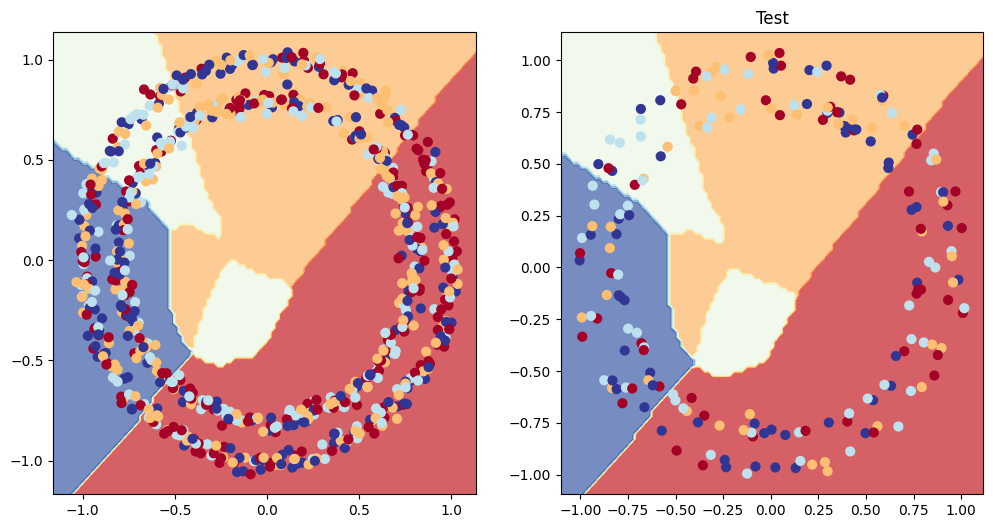

In [150]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plot_decision_boundary(model4, x_train, y_train)
plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model4, x_test, y_test)

### Some more evaluation metrics

- Accuracy
- Precision
- F1 score
- Confusion matrix
- Classification report

Available as part of the torchmetrics python package

In [153]:
!pip install -q torchmetrics

In [155]:
from torchmetrics import Accuracy

toraccu = Accuracy(task='multiclass', num_classes=NUM_CLASSES).to(device)

toraccu(y_pred, y_test)

tensor(0.2850, device='cuda:0')

We reach the end of this notebook.